# Lecture 12 (Neural Networks Continued)

## Convolutional Networks

Having covered the theory of classical fully connected feedforward networks — where the fundamental building block is a composition of affine maps and nonlinear activation functions — it is now natural to seek architectures that can exploit additional **geometric structure** present in certain classes of data, particularly images, spatial data, or any modality exhibiting **locality** and **translation invariance**.

Convolutional Neural Networks, or CNNs, arise precisely as a mathematically principled response to this need. Formally, in a standard fully connected layer, each neuron computes a transformation of the form
$$
x \mapsto \sigma(Wx + b),
$$
where $W \in \mathbb{R}^{m \times d}$ is a dense weight matrix, $b \in \mathbb{R}^m$ is a bias vector, $\sigma$ is an activation function, and $x \in \mathbb{R}^d$ is the input.

In contrast, in a convolutional layer, rather than allowing arbitrary dense interactions between all input and output units, one restricts the transformation to be **local** and **shared** across different spatial regions. Let us model the input as a function
$$
x : \Omega \subset \mathbb{Z}^2 \to \mathbb{R},
$$
where $\Omega$ is a discrete rectangular domain, typically corresponding to pixel locations of a grayscale image. For color images, $x$ would map into $\mathbb{R}^3$, corresponding to RGB channels. Given a small filter, or **kernel**, represented as a function
$$
k : \Delta \subset \mathbb{Z}^2 \to \mathbb{R},
$$
where $\Delta$ is typically a small region such as $\{0,1,2\} \times \{0,1,2\}$ (corresponding to a $3 \times 3$ filter), the **convolution** of $k$ with $x$ at position $(u,v)$ is defined by
$$
(k * x)(u,v) = \sum_{(s,t) \in \Delta} k(s,t) \, x(u-s, v-t).
$$
Thus, the output at each spatial location $(u,v)$ depends only on a small neighborhood of the input centered at $(u,v)$, determined by the size of the kernel $\Delta$. A convolutional layer consists of multiple such kernels $\{k_i\}_{i=1}^n$, each producing its own feature map
$$
y_i(u,v) = \sigma\left( (k_i * x)(u,v) + b_i \right),
$$
where $\sigma$ is a nonlinear activation function such as ReLU, and $b_i \in \mathbb{R}$ is a bias term. The key mathematical principles embodied in CNNs are thus:

1. **local connectivity**: neurons are connected only to small spatial regions of the input.

2. **parameter sharing**: the same kernel $k_i$ is applied across all spatial locations, greatly reducing the number of parameters and introducing a strong inductive bias toward translation invariance.

3. **equivariance to translation**: if the input is shifted, the output feature maps shift correspondingly, preserving spatial structure.

These properties make CNNs particularly well-suited for tasks where the relevant features are local and their precise spatial location is less critical than their relative arrangement.


The construction of a CNN proceeds hierarchically. At the first layer, low-level features such as edges, corners, and simple textures are detected. At deeper layers, the network composes these simple features into progressively more abstract and global representations: motifs, parts, objects. Formally, given an input $x^{(0)} = x$, each layer $l$ computes
$$
x^{(l)} = \sigma\left( k^{(l)} * x^{(l-1)} + b^{(l)} \right),
$$
where $k^{(l)}$ and $b^{(l)}$ are the learnable parameters of layer $l$. Typically, convolutional layers are interleaved with **pooling layers**, which downsample the spatial dimensions to introduce further invariance to small translations or distortions. A common form of pooling is **max pooling**, defined for a small region $R \subset \Omega$ as
$$
\text{MaxPool}(x)(u,v) = \max_{(s,t) \in R} x(u+s,v+t),
$$
which retains only the maximum activation within each local neighborhood.  Thus, a typical CNN architecture consists of alternating convolutional layers, nonlinearities, and pooling layers, culminating in fully connected layers for the final classification or regression tasks.

---

From the perspective of backpropagation, the critical difference with fully connected networks lies in the structure of the Jacobian matrices involved. Whereas in fully connected layers the Jacobians are dense, in convolutional layers they exhibit a **highly sparse, structured pattern** reflecting local connections and weight sharing. However, backpropagation through convolutional layers is entirely analogous in principle: one applies the chain rule, computes local gradients with respect to the weights, inputs, and outputs, and updates parameters accordingly. It is worth noting that the convolution operation is linear, hence differentiable, and the pooling operations are piecewise differentiable, so standard gradient-based optimization techniques such as stochastic gradient descent (SGD) or Adam are applicable without difficulty.



## An example in PyTorch

Let us now proceed formally to construct a **worked example** of a **Convolutional Neural Network (CNN)** implemented in **PyTorch**, trained on the classical **digits dataset**. For mathematical clarity, we shall work with the **scikit-learn digits dataset**, consisting of $8 \times 8$ grayscale images of handwritten digits $\{0,1,\dots,9\}$.  Each image $x$ can be modeled as a function
$$
x: \{0,1,\dots,7\}^2 \to \mathbb{R},
$$
with pixel intensities normalized to $[0,1]$. The classification task consists of learning a function
$$
f_\theta : \mathbb{R}^{8 \times 8} \to \{0,1,\dots,9\},
$$
mapping each input image to its corresponding digit class.  The CNN will be trained to minimize the empirical risk associated to the cross-entropy loss between predicted and true labels. Let us now proceed systematically through the complete PyTorch implementation.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [24]:
digits = load_digits()
X = digits.images  # Shape (1797, 8, 8)
y = digits.target  # Shape (1797,)

X = X / 16.0
X = X[:, None, :, :]  # Add channel dimension: (1797, 1, 8, 8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),         
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 2 * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [12]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
num_epochs = 50
batch_size = 32

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {correct/total:.4f}")

Epoch 10/50, Loss: 0.1401, Accuracy: 0.9645
Epoch 20/50, Loss: 0.0486, Accuracy: 0.9868
Epoch 30/50, Loss: 0.0139, Accuracy: 0.9993
Epoch 40/50, Loss: 0.0076, Accuracy: 0.9993
Epoch 50/50, Loss: 0.0032, Accuracy: 1.0000


Test Accuracy: 0.9972


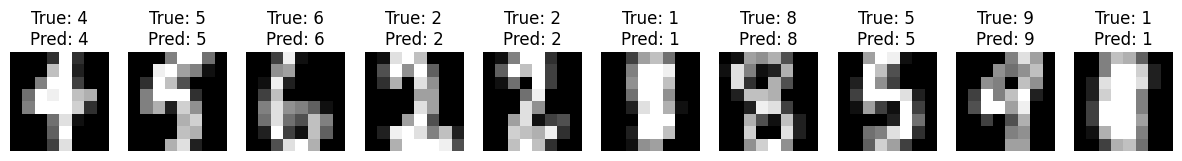

In [25]:
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = outputs.max(1)
    accuracy = (predicted == y_test).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")

def plot_predictions(images, true_labels, pred_labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(images[i,0], cmap='gray')
        axes[i].set_title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}")
        axes[i].axis('off')
    plt.show()

plot_predictions(X_test.numpy(), y_test.numpy(), predicted.numpy(), num_images=10)